https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html 

In [35]:
import numpy as np
import pandas as pd
from sklearn.utils.fixes import parse_version, sp_version
from sklearn.linear_model import QuantileRegressor
import matplotlib.pyplot as plt
import statistics as st

In [36]:
# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [37]:
model_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240807/SOUT/SOUT_loss_0.18919702991843224_ml_output_SOUT.parquet"
)
model_df = model_df.sort_index()
model_df.head()

,target_error_lead_0,Model forecast,diff
0,-0.136394,-0.140973,0.004579
1,0.559516,0.338785,0.220731
2,0.104128,-0.044972,0.149099
3,0.197129,-0.017648,0.214778
4,-0.152429,-0.191227,0.038798


In [38]:
x = model_df["Model forecast"].values
X = x[:, np.newaxis]
y = model_df["diff"].values

In [39]:
quantiles = [0.10, 0.5, 0.90]
predictions = {}
out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    y_pred = qr.fit(X, y).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(out_bounds_predictions, y_pred >= y)
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(out_bounds_predictions, y_pred <= y)

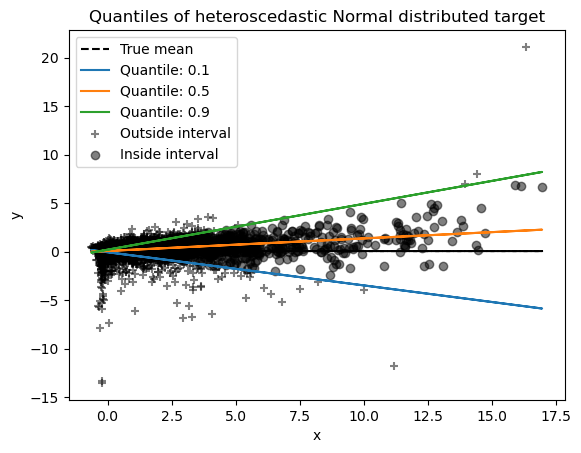

In [40]:
plt.plot(
    X, st.mean(y).repeat(len(X)), color="black", linestyle="dashed", label="True mean"
)

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [41]:
niner = predictions.get(0.9)
for n in niner:
    print(n)

0.13182712794120785
0.35846289465100645
0.1771777698667728
0.19008520692508404
0.10808736262630385
0.11706088428599176
0.16674722816466944
0.45148930049730585
0.2608585590733516
0.1193404693453718
0.11807013032585587
0.11470219912652416
0.09040464330428387
0.09540264757268872
0.07883926118786037
0.07367158977409552
0.12861146988996675
0.2831296825370616
0.19176384336932384
0.19535296421569057
0.21587241677247593
0.1912850944482741
0.18794304570693915
0.12160613779908547
0.09301228576906397
0.08516044111823531
0.07745658270965464
0.07586043180684668
0.07653432777390035
0.07150904639524905
0.06953050912268438
0.06743055879269244
0.07767396895962383
0.07012215844299755
0.08237622599966894
0.0758311062736114
0.09182369360923627
0.08120990604031086
0.08872246567519933
0.16714796587027453
0.1878519014428176
0.17156780275008224
0.2835015241039411
0.2127819386595964
0.6015232899657165
0.3687524260118306
0.2972613374209959
0.36537965180556997
0.26265949596100846
0.13670868182643675
0.1142027781

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(
    f"""Training error (in-sample performance)
    {qr.__class__.__name__}:
    MAE = {mean_absolute_error(y, y_pred):.3f}
    MSE = {mean_squared_error(y, y_pred):.3f}
    """
)

Training error (in-sample performance)
    QuantileRegressor:
    MAE = 0.135
    MSE = 0.198
    


In [43]:
def quantile_regression(x, y):
    X = x[:, np.newaxis]
    quantiles = [0.10, 0.5, 0.90]
    predictions = {}
    out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

    predictions_df = pd.DataFrame()
    predictions_df["target"] = x

    for q in quantiles:
        predictions_df[q] = predictions.get(q)

    return qr, y_pred, predictions_df

In [44]:
qr, y_pred, predictions_df = quantile_regression(x, y)

In [45]:
predictions_df

,0.1,0.5,0.9
0,-0.013138,0.048999,0.131827
1,-0.177260,0.111023,0.358463
2,-0.045979,0.061410,0.177178
3,-0.055327,0.064942,0.190085
4,0.004054,0.042502,0.108087
...,...,...,...
44063,0.018581,0.037011,0.088026
44064,0.007378,0.041245,0.103497
44065,0.016712,0.037718,0.090607
44066,0.017331,0.037484,0.089753
